In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display

%matplotlib inline

In [5]:
x_train = pd.read_csv('C:/Users/HP/Multimodal/pre-processed/s2e/audio_train.csv')
x_test = pd.read_csv('C:/Users/HP/Multimodal/pre-processed/s2e/audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

(7837, 10)


In [6]:
x_train

,wav_file,label,sig_mean,sig_std,rms_mean,rms_std,silence,harmonic,auto_corr_max,auto_corr_std
0,Ses04M_script02_2_M038,4,0.004841,0.010331,0.005035,0.020822,0.298408,0.169859,0.000221,0.000088
1,Ses03M_impro08a_F023,2,0.014103,0.020905,0.014573,0.034341,0.489741,0.171830,0.000701,0.000545
2,Ses02F_impro03_M007,4,0.046714,0.057852,0.049352,0.074707,0.296524,0.171239,0.004401,0.002296
3,Ses01M_impro05_F000,5,0.071723,0.118935,0.074084,0.201607,0.764284,0.171679,0.020934,0.014458
4,Ses05F_script01_2_M004,2,0.008553,0.018058,0.008947,0.034943,0.758333,0.171445,0.000601,0.000538
...,...,...,...,...,...,...,...,...,...,...
7832,Ses04F_impro08_M012,5,0.014352,0.021117,0.014942,0.034313,0.612563,0.171005,0.000712,0.000576
7833,Ses03M_impro04_F023,5,0.013690,0.017359,0.014105,0.024708,0.372635,0.171860,0.000457,0.000461
7834,Ses04F_impro04_M001,5,0.007561,0.010325,0.007827,0.016365,0.505575,0.170818,0.000189,0.000214
7835,Ses01F_script03_2_M015,2,0.008348,0.014455,0.008722,0.026289,0.005061,0.170984,0.000381,0.000324


In [7]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(7837, 10) (1960, 10)
{2: 2342, 5: 1385, 1: 1307, 3: 973, 4: 954, 0: 876}


In [8]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy =  0.575
Test Set F-score =  0.570
Test Set Precision =  0.585
Test Set Recall =  0.579
Confusion matrix, without normalization
[[ 72  39  91   0   7  18]
 [ 35  61 182   1   7  43]
 [ 40  50 419   1  11  70]
 [  0   0   0 267   0   0]
 [  0   0   0   0 223   0]
 [ 13  31 183   1  10  85]]


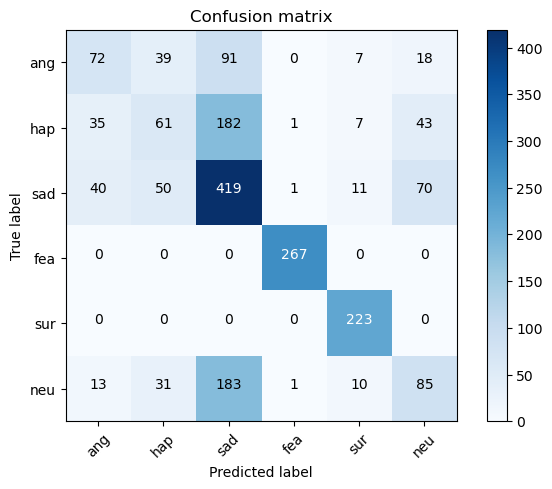

In [9]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/audio/RF.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

Test Set Accuracy =  0.578
Test Set F-score =  0.572
Test Set Precision =  0.587
Test Set Recall =  0.580
Confusion matrix, without normalization
[[ 68  44  95   0   3  17]
 [ 42  65 168   1   3  50]
 [ 35  50 424   5   9  68]
 [  0   0   0 267   0   0]
 [  0   0   0   0 223   0]
 [ 15  33 181   3   6  85]]


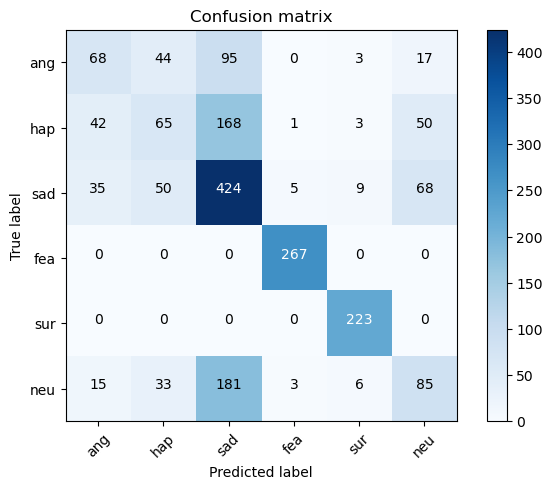

In [9]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=1200, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/audio/XGB.pkl', 'wb') as f:
    pickle.dump(xgb_classifier, f)

Test Set Accuracy =  0.389
Test Set F-score =  0.333
Test Set Precision =  0.401
Test Set Recall =  0.332
Confusion matrix, without normalization
[[ 62  29 107  16   8   5]
 [ 36  49 185  24  11  24]
 [ 28  40 431  48  11  33]
 [  0   0 115 130   6  16]
 [  9  10 122  25  55   2]
 [ 13  19 202  38  16  35]]


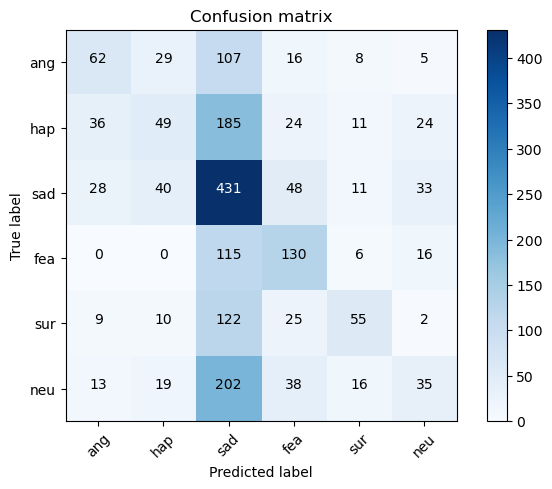

In [10]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(650, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/audio/MLP.pkl', 'wb') as f:
    pickle.dump(mlp_classifier, f)

Test Set Accuracy =  0.389
Test Set F-score =  0.333
Test Set Precision =  0.401
Test Set Recall =  0.332
Confusion matrix, without normalization
[[ 62  29 107  16   8   5]
 [ 36  49 185  24  11  24]
 [ 28  40 431  48  11  33]
 [  0   0 115 130   6  16]
 [  9  10 122  25  55   2]
 [ 13  19 202  38  16  35]]


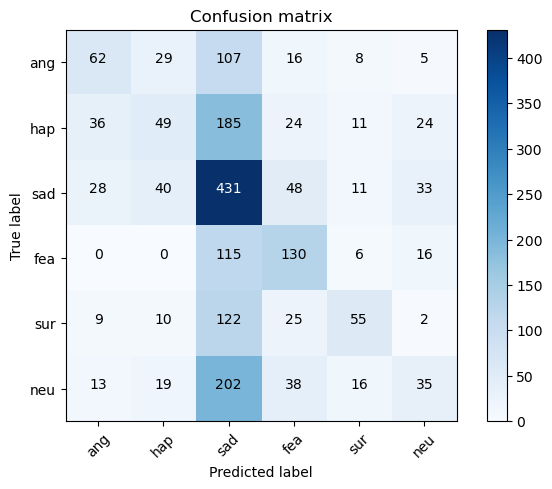

In [11]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
display_results(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/audio/SVC.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.305
Test Set F-score =  0.088
Test Set Precision =  0.125
Test Set Recall =  0.172
Confusion matrix, without normalization
[[  8   3 216   0   0   0]
 [  5   0 324   0   0   0]
 [  2   0 589   0   0   0]
 [  0   0 267   0   0   0]
 [  2   0 221   0   0   0]
 [  1   0 322   0   0   0]]


C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


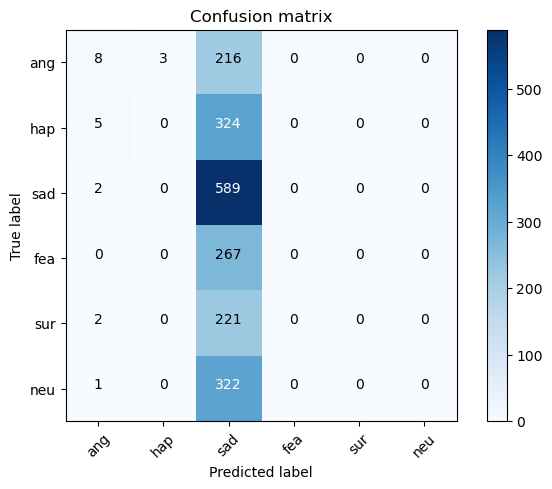

In [12]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/audio/MNB.pkl', 'wb') as f:
    pickle.dump(mnb_classifier, f)

Test Set Accuracy =  0.318
Test Set F-score =  0.140
Test Set Precision =  0.162
Test Set Recall =  0.202
Confusion matrix, without normalization
[[ 49  19 159   0   0   0]
 [ 24  18 287   0   0   0]
 [ 20  15 556   0   0   0]
 [  0   0 267   0   0   0]
 [ 22   9 192   0   0   0]
 [ 10   7 306   0   0   0]]


C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


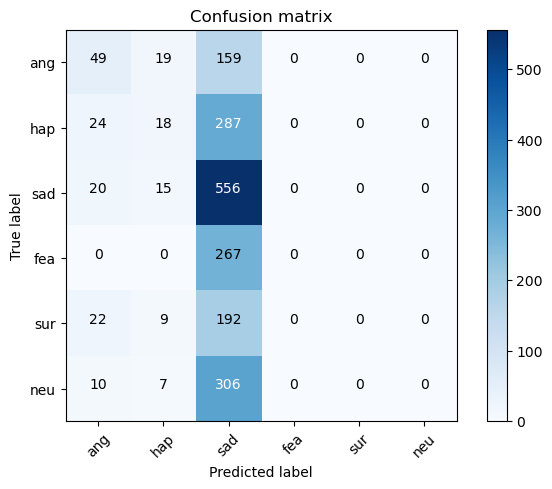

In [13]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/audio/LR.pkl', 'wb') as f:
    pickle.dump(lr_classifier, f)

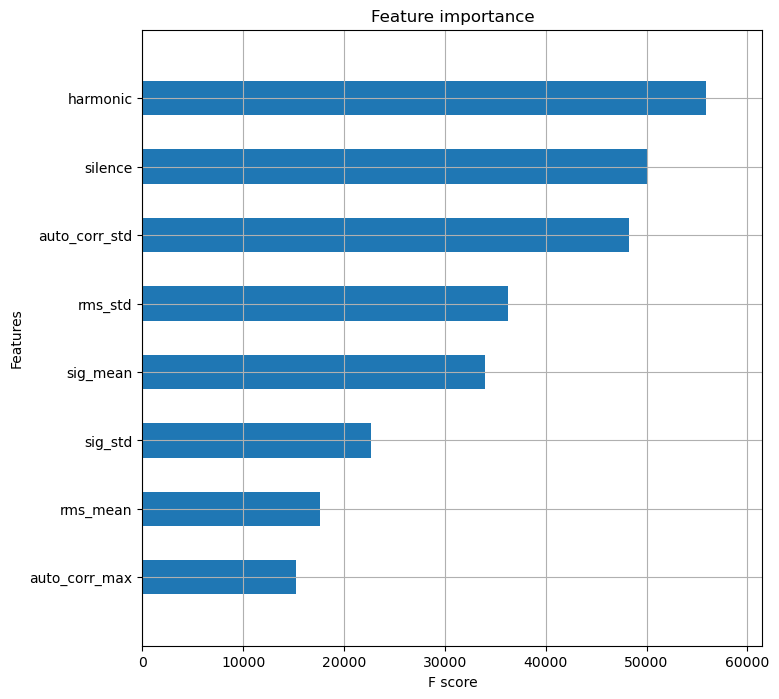

In [11]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)

In [12]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.09974027, 0.11265766, 0.13473791, 0.16932005, 0.1132432 ,
       0.10446964, 0.15909497, 0.10673628], dtype=float32)

In [13]:
top_n = [3, 5, 6, 7, 8]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                              n_estimators=1200, sub_sample = 0.8, num_class = len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)

Stats for top 3 features:


C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Test Set Accuracy =  0.531
Test Set F-score =  0.520
Test Set Precision =  0.530
Test Set Recall =  0.535
Stats for top 5 features:


C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Test Set Accuracy =  0.561
Test Set F-score =  0.556
Test Set Precision =  0.576
Test Set Recall =  0.564
Stats for top 6 features:


C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Test Set Accuracy =  0.567
Test Set F-score =  0.561
Test Set Precision =  0.576
Test Set Recall =  0.570
Stats for top 7 features:


C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Test Set Accuracy =  0.578
Test Set F-score =  0.572
Test Set Precision =  0.587
Test Set Recall =  0.579
Stats for top 8 features:


C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Test Set Accuracy =  0.578
Test Set F-score =  0.572
Test Set Precision =  0.587
Test Set Recall =  0.580


Test Set Accuracy =  0.588
Test Set F-score =  0.573
Test Set Precision =  0.602
Test Set Recall =  0.584
Confusion matrix, without normalization
[[ 74  33 102   0   6  12]
 [ 41  64 180   1   6  37]
 [ 35  40 456   4   9  47]
 [  0   0   0 267   0   0]
 [  0   0   0   0 223   0]
 [ 14  21 211   2   7  68]]


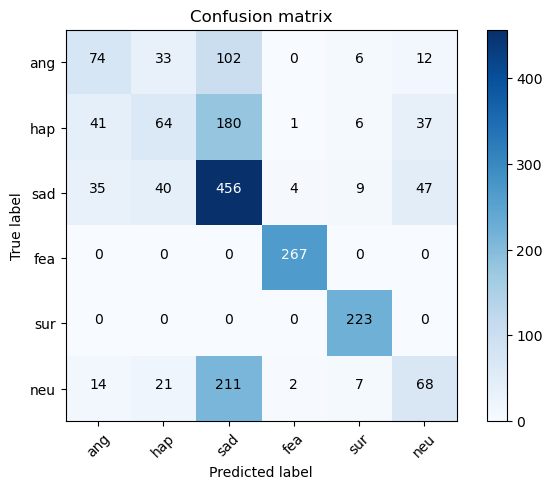

In [14]:
# Load predicted probabilities
# Load predicted probabilities
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

#with open('pred_probas/lstm_classifier.pkl', 'rb') as f:
    #lstm_pred_probs = pickle.load(f)

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs)/3.0
# Show metrics
display_results(y_test, ensemble_pred_probs)